In [1]:
from sklearn import datasets, tree, metrics
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import numpy as np
import scipy
import time
from sklearn.model_selection import train_test_split

In [2]:
##### ustawienia
time_multiplicator = 1
seed = 244810
samples = 2410
#samples = 300

In [3]:
def standarize(arr):
    for col in range(arr.shape[1]):
        xmean = np.mean( arr[:,col])
        xstd = np.std( arr[:,col])
        arr[:,col] = (arr[:,col] - xmean)/xstd
    return arr    
    
def normalize(arr):
    for col in range(arr.shape[1]):
        xmin = min( arr[:,col])
        xmax = max( arr[:,col])
        arr[:,col] = (arr[:,col] - xmin )/(xmax-xmin)
    
    return arr        

In [36]:
def compare_model(sk, my,X_tr, X_te, y_tr, y_te ):
    mycmap = "coolwarm"
    sk_time = time.perf_counter()
    for i in range(time_multiplicator):
        sk.fit(X_tr,y_tr)
    sk_time = (time.perf_counter() - sk_time)/time_multiplicator

    my_time = time.perf_counter()
    for i in range(time_multiplicator):
        my.fit(X_tr,y_tr)
    my_time = (time.perf_counter() - my_time)/time_multiplicator
    
    my_pred = my.predict(X_te)
    sk_pred = sk.predict(X_te)
    
    #graph
    fig, axs = plt.subplots(3, 2,figsize=(12,18))

    mesh = np.meshgrid(np.arange(0, 1.1, 0.01), np.arange(0, 1.1, 0.01))[0]
    sk_predict = sk.predict(np.c_[mesh.ravel(), mesh.T.ravel()]).reshape(mesh.shape)
    my_predict = np.array(my.predict(np.c_[mesh.ravel(), mesh.T.ravel()])).reshape(mesh.shape)
    
    axs[0,0].set_title("Sklearn")
    axs[0,0].contourf(mesh, mesh.T, sk_predict, alpha=0.2,cmap=mycmap)
    axs[0,0].scatter(X_te[:, 0], X_te[:, 1],cmap=mycmap, c=y_te, marker="o", alpha=0.5)
    axs[0,0].scatter(X_tr[:, 0], X_tr[:, 1],cmap=mycmap, c=y_tr, marker="+", alpha=0.2)

    axs[0,1].set_title("Własna implementacja")
    axs[0,1].contourf(mesh, mesh.T, my_predict, alpha=0.2,cmap=mycmap)
    axs[0,1].scatter(X_te[:, 0], X_te[:, 1], c=y_te, marker="o", alpha=0.5,cmap=mycmap)
    axs[0,1].scatter(X_tr[:, 0], X_tr[:, 1], c=y_tr, marker="+", alpha=0.2,cmap=mycmap)
    
    #confusion matrix
    sk_cm = metrics.confusion_matrix(y_te, sk_pred)
    sk_disp = metrics.ConfusionMatrixDisplay(confusion_matrix=sk_cm)
    sk_disp.plot(ax=axs[1,0] ,cmap="plasma")
    # sk_disp.im_.colorbar.remove()

    my_cm = metrics.confusion_matrix(y_te, my_pred)
    my_disp = metrics.ConfusionMatrixDisplay(confusion_matrix=my_cm)
    my_disp.plot(ax=axs[1,1] ,cmap="plasma")
    # my_disp.im_.colorbar.remove()
    my_disp.ax_.set_ylabel('')

    #roc
    fpr, tpr, thresholds = metrics.roc_curve(y_te, sk.predict(X_test))
    roc_auc = metrics.auc(fpr, tpr)
    display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='Sklearn')
    display.plot(ax=axs[2,0])

    fpr, tpr, thresholds = metrics.roc_curve(y_te, my.predict(X_test))
    roc_auc = metrics.auc(fpr, tpr)
    display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='własna implementacja')
    display.plot(ax=axs[2,1])
    
    #metryki
    print('              | Sklearn | Własna')
    print('--------------+---------+----------')
    print(f'Czułość       |{sk_cm[0][0]/(sk_cm[0][0]+sk_cm[1][0]):9.4f}|{my_cm[0][0]/(my_cm[0][0]+my_cm[1][0]):.4f}')
    print(f'Specyficzność |{sk_cm[1][1]/(sk_cm[0][0]+sk_cm[1][1]):9.4f}|{my_cm[1][1]/(my_cm[0][0]+my_cm[1][1]):.4f}')
    print(f'Skuteczność   |{metrics.accuracy_score(sk_pred, y_test):9.4f}|{metrics.accuracy_score(my_pred, y_test):.4f}')
    print(f'Czas wykonania|{sk_time:9.2E}|{my_time:.2E}')
    print(f'BACC          |{metrics.balanced_accuracy_score(sk_pred, y_test,adjusted=False):9.4f}|{metrics.balanced_accuracy_score(my_pred, y_test,adjusted=False):.4f}')

In [13]:
class Node():
    def __init__(self, feature_index=None, threshold=None, left=None, right=None, info_gain=None, value=None):
        self.feature_index = feature_index
        self.threshold = threshold
        self.left = left
        self.right = right
        self.info_gain = info_gain
        
        self.value = value

In [14]:
class myTree():
    def __init__(self, min_samples_split=2, max_depth=2):
        self.root = None

        self.min_samples = min_samples_split
        self.max_depth = max_depth

    def build_tree(self, X, Y, curr_depth=0):
        num_samples, num_features = np.shape(X)

        if num_samples>=self.min_samples and curr_depth<=self.max_depth:
            best_split = self.get_best_split(X, Y, num_samples, num_features)
            if best_split["info_gain"]>0:
                left_subtree = self.build_tree(best_split["X_left"],best_split["Y_left"], curr_depth+1)
                right_subtree = self.build_tree(best_split["X_right"],best_split["Y_right"], curr_depth+1)
                return Node(best_split["feature_index"], best_split["threshold"], 
                            left_subtree, right_subtree, best_split["info_gain"])

        leaf_value = self.calculate_leaf_value(Y)
        return Node(value=leaf_value)
    
    def get_best_split(self, X, Y, num_samples, num_features):
        best_split = {}
        max_info_gain = -float("inf")
        
        for feature_index in range(num_features):
            feature_values = X[:, feature_index]
            possible_thresholds = np.unique(feature_values)
            for threshold in possible_thresholds:
                X_left, Y_left, X_right, Y_right = self.split(X, Y, feature_index, threshold)
                if len(X_left)>0 and len(X_right)>0:
                    curr_info_gain = self.information_gain(Y, Y_left, Y_right)
                    if curr_info_gain>max_info_gain:
                        best_split["feature_index"] = feature_index
                        best_split["threshold"] = threshold
                        best_split["X_left"] = X_left
                        best_split["X_right"] = X_right
                        best_split["Y_left"] = Y_left
                        best_split["Y_right"] = Y_right
                        best_split["info_gain"] = curr_info_gain
                        max_info_gain = curr_info_gain
        return best_split
    
    def split(self, X, Y, feature_index, threshold):
        X_left = []
        Y_left = []
        X_right = []
        Y_right = []
        for i, row in enumerate(X):
            if row[feature_index] <= threshold:
                X_left.append(row)
                Y_left.append(Y[i])
            else:
                X_right.append(row)
                Y_right.append(Y[i])
        
        return  np.array(X_left), np.array(Y_left), np.array(X_right), np.array(Y_right)
    
    def information_gain(self, parent, l_child, r_child):
        weight_l = len(l_child) / len(parent)
        weight_r = len(r_child) / len(parent)
        gain = self.entropy(parent) - (weight_l*self.entropy(l_child) + weight_r*self.entropy(r_child))
        return gain
    
    def entropy(self, y):
        class_labels = np.unique(y)
        entropy = 0
        for cls in class_labels:
            p_cls = len(y[y == cls]) / len(y)
            entropy += -p_cls * np.log2(p_cls)
        return entropy    
    
    def calculate_leaf_value(self, Y):
        Y = list(Y)
        return max(Y, key=Y.count)
    
    def fit(self, X, Y):
        self.root = self.build_tree(X,Y)
    
    def predict(self, X):
        preditions = [self.make_prediction(x, self.root) for x in X]
        return preditions
    
    def make_prediction(self, x, tree):
        if tree.value!=None: return tree.value
        feature_val = x[tree.feature_index]
        if feature_val<=tree.threshold:
            return self.make_prediction(x, tree.left)
        else:
            return self.make_prediction(x, tree.right)

In [15]:
X, y  = datasets.make_classification(n_features=2, n_clusters_per_class=1,n_redundant=0,n_samples=samples, random_state=seed)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train = normalize(X_train)
X_test = normalize(X_test)

              | Sklearn | Własna
--------------+---------+----------
Czułość       |   0.9444|0.9737
Specyficzność |   0.5256|0.5110
Skuteczność   |   0.8921|0.9419
Czas wykonania| 3.92E-03|1.70E+01
BACC          |   0.8970|0.9435


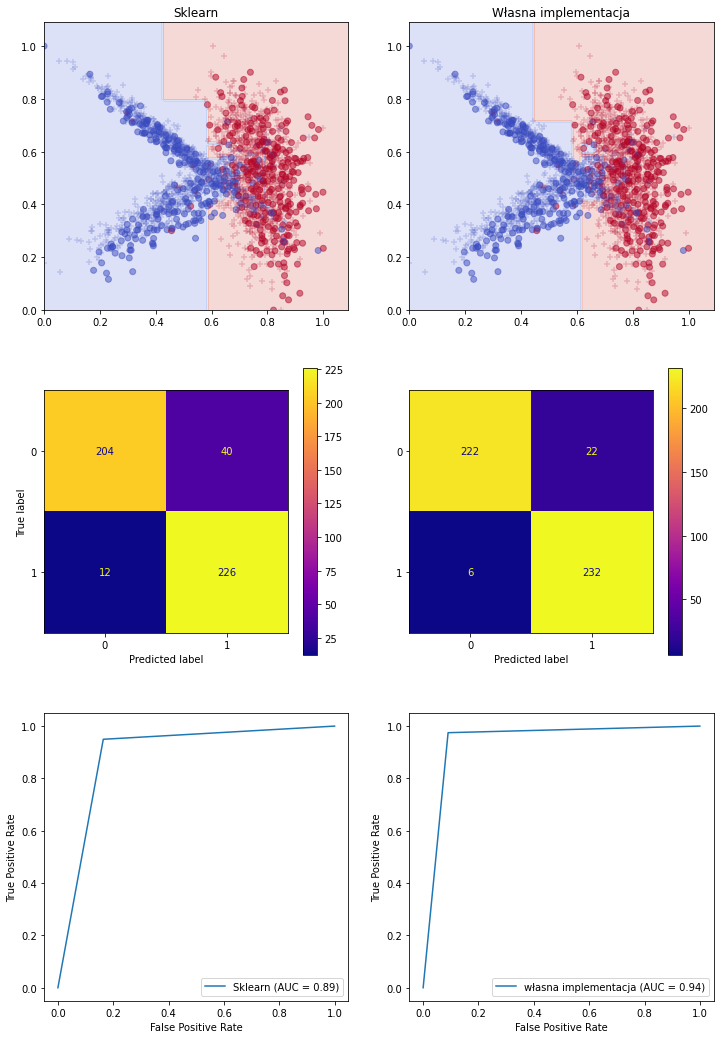

In [37]:
my_model = myTree(min_samples_split=3, max_depth=5)
sk_model = tree.DecisionTreeClassifier()
compare_model(sk_model, my_model ,X_train, X_test, y_train, y_test)

              | Sklearn | Własna
--------------+---------+----------
Czułość       |   0.9398|0.9780
Specyficzność |   0.5257|0.5121
Skuteczność   |   0.8880|0.9440
Czas wykonania| 4.27E-03|1.50E+01
BACC          |   0.8928|0.9458


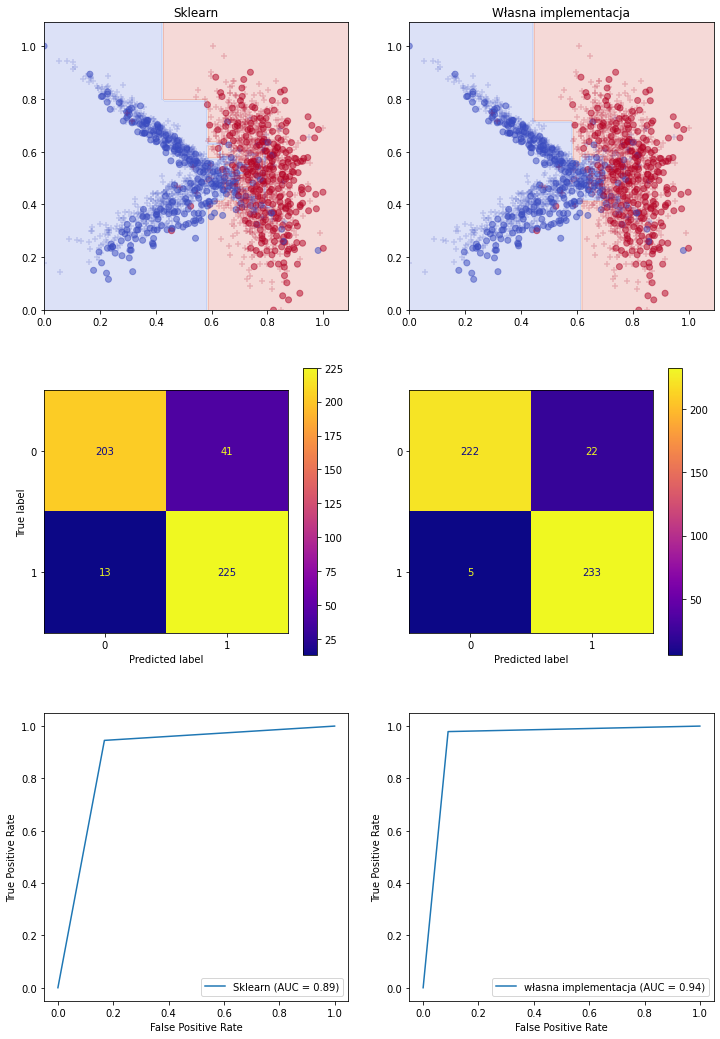

In [38]:
my_model2 = myTree(min_samples_split=3, max_depth=3)
sk_model2 = tree.DecisionTreeClassifier()
X, y  = datasets.make_classification(n_features=2, n_clusters_per_class=2,n_redundant=0,
                                     n_samples=samples,
                                     random_state=seed, class_sep=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train = normalize(X_train)
X_test = normalize(X_test)
compare_model(sk_model2, my_model2 ,X_train, X_test, y_train, y_test)